<a href="https://colab.research.google.com/github/harikarce/Depression-Risk-Prediction/blob/main/Mental_Health_Survey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive (optional if your data is in Drive)
from google.colab import drive
drive.mount('/content/drive')

# Install dependencies if not pre-installed
!pip install tensorflow scikit-learn pandas numpy matplotlib seaborn imbalanced-learn


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# Update the path if your files are in Drive
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print("✅ Train Shape:", train_df.shape)
print("✅ Test Shape:", test_df.shape)
train_df.head()


✅ Train Shape: (140700, 20)
✅ Test Shape: (93800, 19)


,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

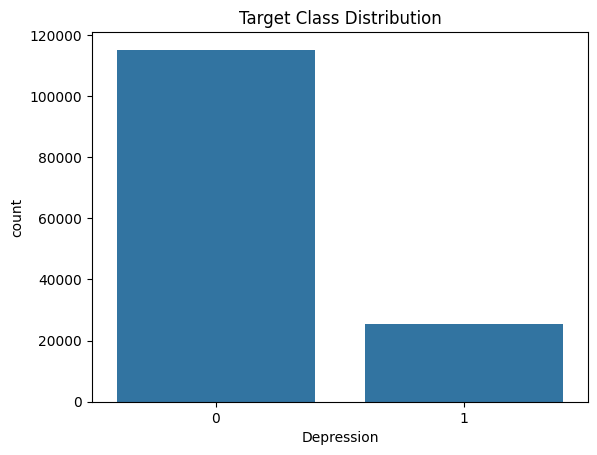

In [ ]:
# Quick summary
train_df.info()
train_df.describe()

# Check missing values
print(train_df.isnull().sum())

# Target distribution
sns.countplot(x='Depression', data=train_df)
plt.title('Target Class Distribution')
plt.show()


In [ ]:
# ============================================
# 🧹 Step 5: Data Cleaning & Missing Value Handling
# ============================================

import pandas as pd

# 1️⃣ Drop Irrelevant Columns — only if they exist
irrelevant_cols = ['id', 'Name']
train_df = train_df.drop(columns=[col for col in irrelevant_cols if col in train_df.columns])
test_df = test_df.drop(columns=[col for col in irrelevant_cols if col in test_df.columns])

# 2️⃣ Identify Numeric and Categorical Columns
num_cols = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
            'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours',
            'Financial Stress', 'Depression']

cat_cols = ['Gender', 'City', 'Working Professional or Student', 'Profession',
            'Sleep Duration', 'Dietary Habits', 'Degree',
            'Have you ever had suicidal thoughts ?',
            'Family History of Mental Illness']

# 3️⃣ Fill Missing Values

## For Training Data
# Numeric → median
train_df[num_cols] = train_df[num_cols].fillna(train_df[num_cols].median())

# Categorical → mode (most frequent)
for col in cat_cols:
    if col in train_df.columns:
        train_df[col] = train_df[col].fillna(train_df[col].mode()[0])

## For Test Data
# For test data, skip 'Depression' because it’s target (not present in test)
test_num_cols = [col for col in num_cols if col in test_df.columns]

# Numeric → median
test_df[test_num_cols] = test_df[test_num_cols].fillna(test_df[test_num_cols].median())

# Categorical → mode
for col in cat_cols:
    if col in test_df.columns:
        test_df[col] = test_df[col].fillna(test_df[col].mode()[0])

# 4️⃣ Verify Completion
print("✅ Missing values handled successfully!")
print("Numeric Columns:", num_cols)
print("Categorical Columns:", cat_cols)


✅ Missing values handled successfully!
Numeric Columns: ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress', 'Depression']
Categorical Columns: ['Gender', 'City', 'Working Professional or Student', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']


In [ ]:
# ============================================
# ⚙️ Step 6: Encoding & Feature Scaling
# ============================================

from sklearn.preprocessing import LabelEncoder, StandardScaler

# 1️⃣ Label Encode categorical features (same mapping for train & test)
le_dict = {}

for col in cat_cols:
    le = LabelEncoder()

    # Fit on combined unique values from train and test to avoid unseen labels
    combined_values = pd.concat([train_df[col], test_df[col]], axis=0).astype(str)
    le.fit(combined_values)

    # Transform
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))

    le_dict[col] = le  # store encoder for possible future use

print("✅ All categorical columns encoded successfully!")

# 2️⃣ Separate features (X) and target (y)
X_train = train_df.drop(columns=['Depression'])
y_train = train_df['Depression']

# 3️⃣ Apply Standard Scaling (only to numeric columns except target)
scaler = StandardScaler()
X_train[num_cols[:-1]] = scaler.fit_transform(X_train[num_cols[:-1]])

# Apply same scaling to test data (numeric columns present in test)
test_numeric_cols = [col for col in num_cols if col in test_df.columns]
test_df[test_numeric_cols] = scaler.transform(test_df[test_numeric_cols])

print("✅ Scaling applied successfully!")

# 4️⃣ Verify transformations
print("\nSample Encoded & Scaled Data (Train):")
print(X_train.head(3))


✅ All categorical columns encoded successfully!
✅ Scaling applied successfully!

Sample Encoded & Scaled Data (Train):
   Gender       Age  City  Working Professional or Student  Profession  \
0       0  0.695360    62                                1          13   
1       1 -1.161867   118                                1          71   
2       1 -0.596624   123                                0          71   

   Academic Pressure  Work Pressure      CGPA  Study Satisfaction  \
0          -0.045698       1.589714  0.033784            0.018013   
1          -0.045698       0.795176  0.033784            0.018013   
2           3.194278       0.000638  1.869755           -1.632006   

   Job Satisfaction  Sleep Duration  Dietary Habits  Degree  \
0         -0.772518              38              11      50   
1          0.016183              35              32      92   
2          0.016183              17              11      34   

   Have you ever had suicidal thoughts ?  Work/Study H

In [ ]:
# ============================================
# 🧠 Step 7: Build and Train Deep Learning Model
# ============================================

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# 1️⃣ Split the data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# 2️⃣ Define the MLP architecture
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# 3️⃣ Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# 4️⃣ Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# 5️⃣ Train the model
history = model.fit(
    X_train_split, y_train_split,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)

# 6️⃣ Evaluate on validation data
val_loss, val_acc, val_prec, val_recall = model.evaluate(X_val, y_val, verbose=0)
f1_score_val = 2 * (val_prec * val_recall) / (val_prec + val_recall + 1e-7)

print("\n✅ Model Evaluation:")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Precision: {val_prec:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1-Score: {f1_score_val:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
440/440 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7164 - loss: 0.5450 - precision: 0.3744 - recall: 0.6446 - val_accuracy: 0.9300 - val_loss: 0.1801 - val_precision: 0.8702 - val_recall: 0.7223
Epoch 2/30
440/440 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9236 - loss: 0.2012 - precision: 0.8040 - recall: 0.7647 - val_accuracy: 0.9224 - val_loss: 0.1836 - val_precision: 0.7388 - val_recall: 0.8862
Epoch 3/30
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9276 - loss: 0.1839 - precision: 0.8066 - recall: 0.7881 - val_accuracy: 0.9366 - val_loss: 0.1611 - val_precision: 0.8321 - val_recall: 0.8154
Epoch 4/30
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9293 - loss: 0.1781 - precision: 0.8135 - recall: 0.7978 - val_accuracy: 0.9356 - val_loss: 0.1632 - val_precision: 0.8656 - val_recall: 0.7645
Epoch 5/30
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9300 - loss: 0.1760 - precision: 0.8193 - recall: 0.7923 - val_accuracy: 0.9362 - val_loss: 0

In [ ]:
# -----------------------------------------------
# 🧩 Define X_test properly before making predictions
# -----------------------------------------------

# Drop target column if it exists (safety check)
if 'Depression' in test_df.columns:
    X_test = test_df.drop(columns=['Depression'])
else:
    X_test = test_df.copy()

# Ensure column order matches training data
X_test = X_test[X_train.columns]

print("✅ X_test is ready for prediction. Shape:", X_test.shape)


✅ X_test is ready for prediction. Shape: (93800, 17)


In [ ]:
# ============================================
# 🪄 Step 8: Predict on Test Data and Create Submission (Final)
# ============================================

import numpy as np
import pandas as pd

# 1️⃣ Prepare X_test properly
if 'Depression' in test_df.columns:
    X_test = test_df.drop(columns=['Depression'])
else:
    X_test = test_df.copy()

# Ensure same column order as training
X_test = X_test[X_train.columns]

# 2️⃣ Generate predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int).ravel()

# 3️⃣ Handle test IDs safely
if 'id' in test_df.columns:
    submission = pd.DataFrame({
        'id': test_df['id'],
        'Depression': y_pred
    })
else:
    # If no ID column exists in test data
    submission = pd.DataFrame({
        'id': np.arange(1, len(y_pred) + 1),
        'Depression': y_pred
    })

# 4️⃣ Save submission file
submission.to_csv('submission.csv', index=False)
print("✅ submission.csv created successfully!")

# 5️⃣ Preview results
print(submission.head())


2932/2932 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
✅ submission.csv created successfully!
   id  Depression
0   1           0
1   2           0
2   3           0
3   4           1
4   5           0


In [ ]:
# ============================================
# ⚙️ Step 9: Model Optimization using Keras Tuner
# ============================================

!pip install keras-tuner --quiet

import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

# 1️⃣ Define a model-building function
def build_model(hp):
    model = tf.keras.Sequential()

    # Input layer
    model.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))

    # Tune number of hidden layers: 1–3
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(tf.keras.layers.Dense(
            units=hp.Int(f'units_{i}', min_value=64, max_value=256, step=64),
            activation='relu'
        ))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(
            rate=hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1)
        ))

    # Output layer
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Tune learning rate for Adam optimizer
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    return model

# 2️⃣ Initialize tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,        # try more (10–20) for deeper exploration
    executions_per_trial=1,
    overwrite=True,
    directory='tuner_results',
    project_name='depression_prediction'
)

# 3️⃣ Perform hyperparameter search
tuner.search(
    X_train_split, y_train_split,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=256,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
    verbose=1
)

# 4️⃣ Get best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
✅ Best Hyperparameters Found:
- Layers: {best_hps.get('num_layers')}
- Learning Rate: {best_hps.get('learning_rate')}
""")
for i in range(best_hps.get('num_layers')):
    print(f"Layer {i+1}: units={best_hps.get(f'units_{i}')}, dropout={best_hps.get(f'dropout_{i}'):.2f}")

# 5️⃣ Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history_best = best_model.fit(
    X_train_split, y_train_split,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=256,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

# 6️⃣ Evaluate optimized model
val_loss, val_acc, val_prec, val_recall = best_model.evaluate(X_val, y_val, verbose=0)
f1_score_val = 2 * (val_prec * val_recall) / (val_prec + val_recall + 1e-7)

print("\n✅ Optimized Model Performance:")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Precision: {val_prec:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1-Score: {f1_score_val:.4f}")


Trial 5 Complete [00h 00m 43s]
val_accuracy: 0.9371357560157776

Best val_accuracy So Far: 0.9372423887252808
Total elapsed time: 00h 03m 45s

✅ Best Hyperparameters Found:
- Layers: 3
- Learning Rate: 0.0001

Layer 1: units=192, dropout=0.20
Layer 2: units=192, dropout=0.30
Layer 3: units=64, dropout=0.20
Epoch 1/30
440/440 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5771 - loss: 0.7745 - precision_3: 0.2436 - recall_3: 0.6359 - val_accuracy: 0.7784 - val_loss: 0.5151 - val_precision_3: 0.4357 - val_recall_3: 0.7450
Epoch 2/30
440/440 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7424 - loss: 0.5390 - precision_3: 0.3786 - recall_3: 0.6527 - val_accuracy: 0.9010 - val_loss: 0.3183 - val_precision_3: 0.7351 - val_recall_3: 0.7111
Epoch 3/30
440/440 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8536 - loss: 0.3849 - precision_3: 0.5800 - recall_3: 0.7115 - val_accuracy: 0.9156 - val_loss: 0.2294 - val_precision_3: 0.8887 - val_recall_3: 0.6124
Epoch 4/30
440/440 ━━━━━━━━━━━━━━━━

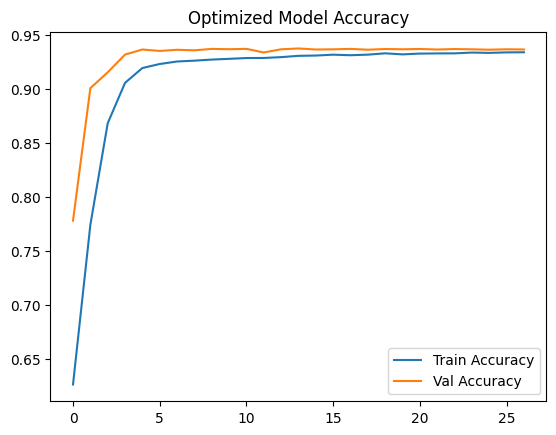

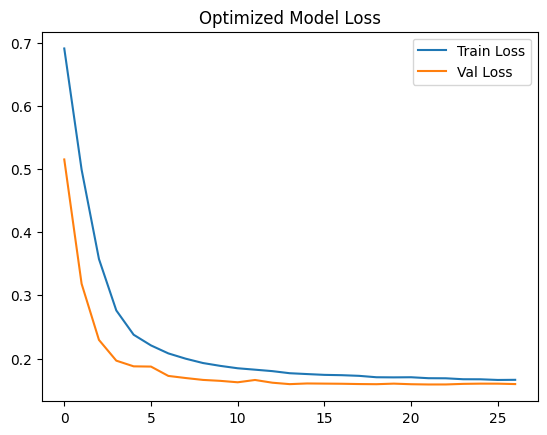

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_best.history['accuracy'], label='Train Accuracy')
plt.plot(history_best.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Optimized Model Accuracy')
plt.show()

plt.plot(history_best.history['loss'], label='Train Loss')
plt.plot(history_best.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Optimized Model Loss')
plt.show()



🔹 Fairness Evaluation by Gender:


,Gender,Samples,Accuracy,Precision,Recall,F1
0,0,2613,0.712974,0.164009,0.158242,0.161074
1,1,3084,0.708495,0.179924,0.169340,0.174472


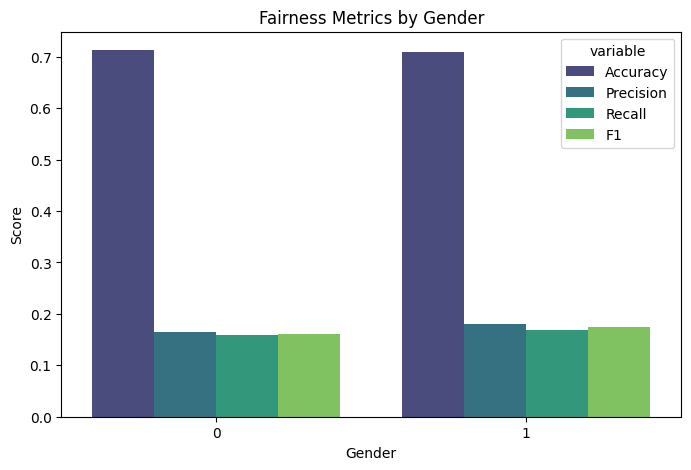


🔹 Fairness Evaluation by Age_Group:


,Age_Group,Samples,Accuracy,Precision,Recall,F1
0,Above Avg,1246,0.800963,0.000000,0.000000,0.000000
1,Adult,1749,0.830189,0.000000,0.000000,0.000000
2,Below Avg,1279,0.438624,0.180645,0.627803,0.280561
3,Young Adult,1423,0.728742,0.144385,0.106719,0.122727


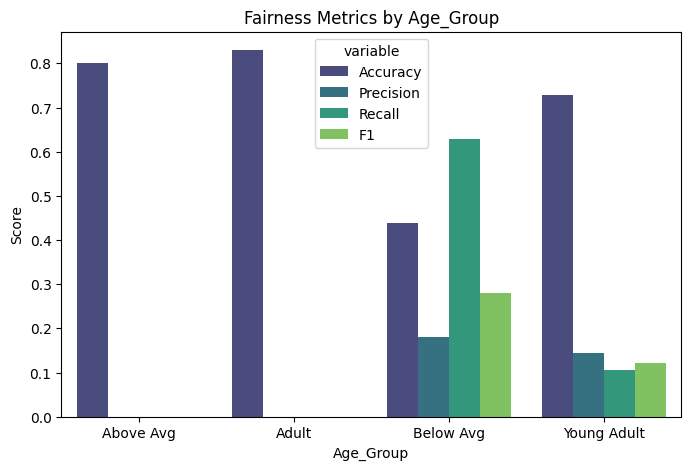


🔹 Fairness Evaluation by Working Professional or Student:


,Working Professional or Student,Samples,Accuracy,Precision,Recall,F1
0,0,1074,0.426443,0.172043,0.592593,0.266667
1,1,4623,0.776552,0.174051,0.066505,0.096238


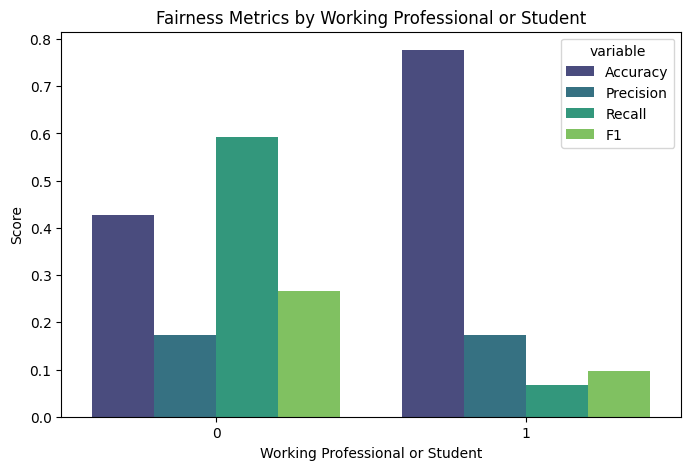


⚙️ Computing SHAP values safely using KernelExplainer (this may take a few minutes)...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

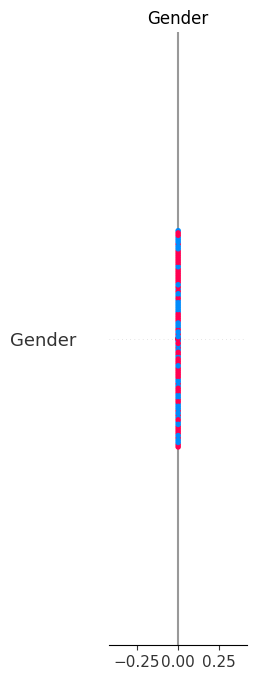

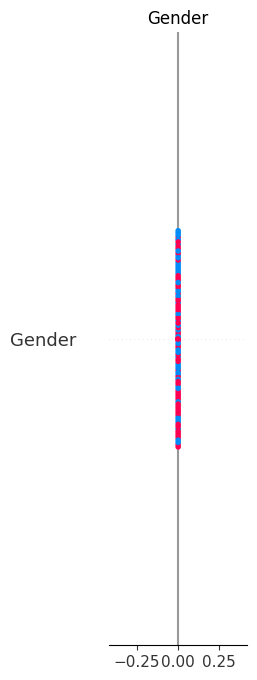

In [ ]:
# ==========================================================
# 🧭 STEP 10 FIXED: FAIRNESS + SHAP EXPLAINABILITY
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import shap

# ==========================================================
# ⚙️ FIX AGE BINNING
# ==========================================================
# Create age bins for fairness
val_results['Age_Group'] = pd.cut(
    val_results['Age'],
    bins=[-np.inf, -1, 0, 1, np.inf],
    labels=['Below Avg', 'Young Adult', 'Adult', 'Above Avg']
)

# ==========================================================
# ⚖️ FAIRNESS EVALUATION
# ==========================================================
demographic_cols = ['Gender', 'Age_Group', 'Working Professional or Student']

def group_metrics(df, group_col):
    metrics = []
    for group in sorted(df[group_col].dropna().unique()):
        subset = df[df[group_col] == group]
        if len(subset) < 10:  # skip small groups
            continue
        acc = accuracy_score(subset['Actual'], subset['Predicted'])
        prec = precision_score(subset['Actual'], subset['Predicted'], zero_division=0)
        rec = recall_score(subset['Actual'], subset['Predicted'], zero_division=0)
        f1 = f1_score(subset['Actual'], subset['Predicted'], zero_division=0)
        metrics.append([group, len(subset), acc, prec, rec, f1])
    return pd.DataFrame(metrics, columns=[group_col, 'Samples', 'Accuracy', 'Precision', 'Recall', 'F1'])

# Evaluate bias for demographics
for col in demographic_cols:
    if col in val_results.columns:
        print(f"\n🔹 Fairness Evaluation by {col}:")
        fairness_df = group_metrics(val_results, col)
        display(fairness_df)

        fairness_melt = fairness_df.melt(id_vars=[col], value_vars=['Accuracy', 'Precision', 'Recall', 'F1'])
        plt.figure(figsize=(8, 5))
        sns.barplot(data=fairness_melt, x=col, y='value', hue='variable', palette='viridis')
        plt.title(f'Fairness Metrics by {col}')
        plt.ylabel('Score')
        plt.xlabel(col)
        plt.show()

# ==========================================================
# 🔍 SHAP EXPLAINABILITY (KernelExplainer for TensorFlow >= 2.4)
# ==========================================================
!pip install shap --quiet
import shap

print("\n⚙️ Computing SHAP values safely using KernelExplainer (this may take a few minutes)...")

# Use a small sample for interpretability
X_sample = X_val[:100]
X_background = X_train_split[:50]

# Define a prediction function for SHAP
f = lambda x: best_model.predict(x)

# KernelExplainer works with any model type
explainer = shap.KernelExplainer(f, X_background)
shap_values = explainer.shap_values(X_sample)

print("✅ SHAP values computed successfully!")

# ==========================================================
# 🌍 GLOBAL FEATURE IMPORTANCE
# ==========================================================
shap.summary_plot(shap_values, X_sample, feature_names=X_train.columns, plot_type='bar')

# ==========================================================
# 💡 FEATURE IMPACT SUMMARY
# ==========================================================
shap.summary_plot(shap_values, X_sample, feature_names=X_train.columns)


In [ ]:
best_model.save("best_model.keras")


In [20]:
import joblib

# Assuming X_train is your training DataFrame after preprocessing
feature_names = list(X_train.columns)
joblib.dump(feature_names, "feature_names.pkl")


['feature_names.pkl']

In [21]:
import joblib
joblib.dump(scaler, "scaler.pkl")
joblib.dump(le_dict, "label_encoders.pkl")


['label_encoders.pkl']